# Sample design: stratified random sample

In [1]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import shapely
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
import geopandas as gpd
import xarray as xr
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler

import statsmodels.api as sm

from sklearn import cluster
from sklearn import neighbors
from sklearn import mixture

/Users/etriesch/.pyenv/versions/3.9.5/envs/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
plt.rcParams.update({'font.size': 18})
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

## Read in temp and color data

In [4]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_clean_path = repo_path / 'data/clean/'
data_raw_path = repo_path / 'data/raw/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'

In [5]:
# read data
t_raw = pd.read_csv(data_clean_path / 'sst.csv')
c_raw = pd.read_csv(data_clean_path / 'chlor_a.csv')
# c_ann_raw = pd.read_csv(data_clean_path / 'chlor_a_annual.csv')

In [6]:
# merge on x/y values
m = pd.merge(left=c_raw, right=t_raw, how='inner', on=['x', 'y'], suffixes=('_c', '_t'))

In [7]:
# scalarize
scale_cols = ['std_c', 'max_c', 'mean_c', 'below_mean', 'months_below_mean', 'bimodal_chl', 'std_t', 'max_t', 'mean_t']
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(m[scale_cols])
m_scaled = pd.DataFrame(scaler.transform(m[scale_cols]), columns=scale_cols)

m_scaled = pd.merge(left=m[['pacific_c', 'lat_c', 'lon_c', 'x', 'y']], right=m_scaled, left_index=True, right_index=True)

In [8]:
# make geodataframe
geo = [Point(lon, lat) for lat, lon in zip(m_scaled.lat_c, m_scaled.lon_c)]
geo_m = gpd.GeoDataFrame(m_scaled, geometry=geo, crs=geo_crs)

## Subset to sample zones

In [9]:
# load coastlines (saved locally)
boundary_fp = data_raw_path / 'stanford-vg541kt0643-shapefile.zip'
boundary = gpd.read_file(data_raw_path / boundary_fp).to_crs(geo_crs)

In [10]:
# Monterrey desal mask
ca_cent = [-121.788649, 36.802834]
ca_lats = [33.48, 39.48]
ca_lons = [-125.48, -119.48]
# Texas desal mask
tx_cent = [-95.311296, 28.927239]
tx_lats = [25.57, 31.57]
tx_lons = [-98.21, -92.21]
# NH desal mask
nh_cent = [-70.799678, 42.563588]
nh_lats = [39.38, 45.38]
nh_lons = [-73.50, -67.50]

In [11]:
# make disks
BUFFER = 1.5
ca_disc = gpd.GeoSeries(Point(ca_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
ca_disc = gpd.GeoDataFrame(geometry=ca_disc)
tx_disc = gpd.GeoSeries(Point(tx_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
tx_disc = gpd.GeoDataFrame(geometry=tx_disc)
nh_disc = gpd.GeoSeries(Point(nh_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
nh_disc = gpd.GeoDataFrame(geometry=nh_disc)
# cut discs at coastal boundary
ca = ca_disc.overlay(boundary, how='difference')
tx = tx_disc.overlay(boundary, how='difference')
nh = nh_disc.overlay(boundary, how='difference')

In [12]:
# make sample zones
pac_sample = geo_m.overlay(ca, how='intersection')
atl_sample = geo_m.overlay(nh, how='intersection')
gul_sample = geo_m.overlay(tx, how='intersection')

In [13]:
# make tuples of sample zones, discs, and desalination plant locations
PAC = [pac_sample, ca, ca_cent] # pacific
ATL = [atl_sample, nh, nh_cent] # atlantic
GUL = [gul_sample, tx, tx_cent] # gulf

sample_locations = [pac_sample, atl_sample, gul_sample]

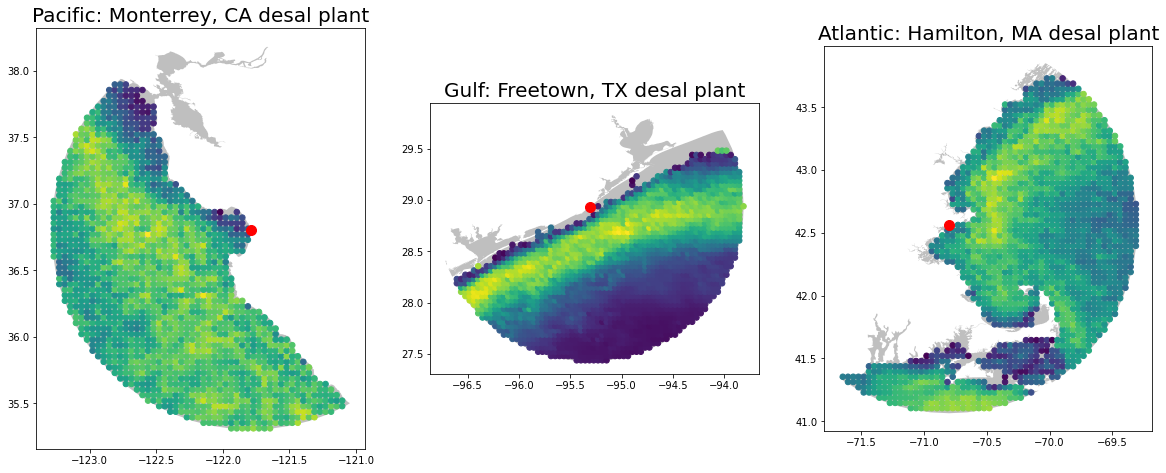

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,20))

# pacific
PAC[1].plot(ax=ax1, alpha=0.5, color='gray')
PAC[0].plot(ax=ax1, column='std_c', markersize=30)
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax1, color='r', markersize=100)
ax1.set_title('Pacific: Monterrey, CA desal plant')
# gulf
GUL[1].plot(ax=ax2, alpha=0.5, color='gray')
GUL[0].plot(ax=ax2, column='std_c', markersize=30)
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax2, color='r', markersize=100)
ax2.set_title('Gulf: Freetown, TX desal plant')
# atlantic
ATL[1].plot(ax=ax3, alpha=0.5, color='gray')
ATL[0].plot(ax=ax3, column='std_c', markersize=30)
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax3, color='r', markersize=100)
ax3.set_title('Atlantic: Hamilton, MA desal plant')

plt.show()

# Generate strata through clustering

In [15]:
def get_cluster_ids(df, var, cluster_method, kw):
    cl = cluster_method.set_params(**kw)
    cl.fit(df[var])
    return cl.labels_

In [16]:
# get kmeans clusters
CLUSTERS = 5
kw = {'n_clusters':CLUSTERS}
cluster_vars = ['lat_c', 'lon_c']
for s in sample_locations:
    s['kmeans_cluster'] = get_cluster_ids(s, cluster_vars, cluster.KMeans(), kw)

In [17]:
# get agglomerative clusters
CLUSTERS = 5
cluster_vars = ['lat_c', 'lon_c', 'max_t', 'std_c', 'months_below_mean', 'below_mean']

for s in sample_locations:
    cmap = neighbors.kneighbors_graph(s[['lat_c', 'lon_c']].values, n_neighbors=6, mode='connectivity', include_self=True)
    kw = {'n_clusters':CLUSTERS, 'connectivity':cmap, 'linkage':'ward'}
    s['agg_cluster'] = get_cluster_ids(s, cluster_vars, cluster.AgglomerativeClustering(), kw)

In [18]:
# get gaussian mixture clusters
# CLUSTERS = 5
cluster_vars = ['lat_c', 'lon_c', 'max_t', 'std_c', 'months_below_mean', 'below_mean']

for s in sample_locations:
    cmap = neighbors.kneighbors_graph(s[['lat_c', 'lon_c']].values, n_neighbors=6, mode='connectivity', include_self=True)
    cl = mixture.GaussianMixture(n_components=CLUSTERS, random_state=111)
    s['gaus_cluster'] = cl.fit_predict(s[cluster_vars])

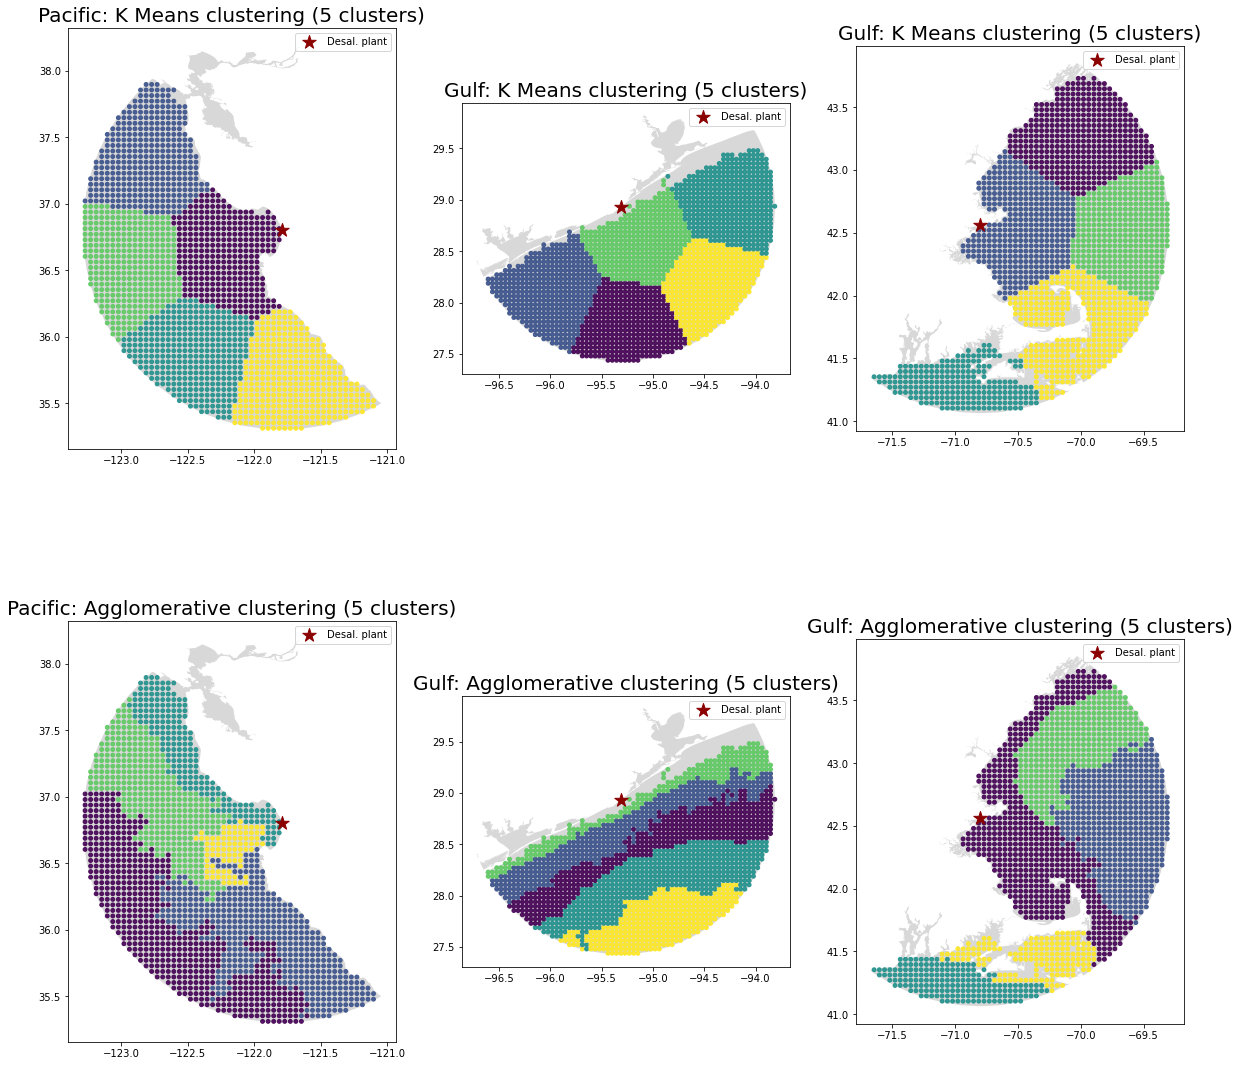

In [19]:
# plot clusters with raster data
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,20))
# PACIFIC
# kmeans
PAC[1].plot(ax=ax[0,0], alpha=0.3, color='gray')
PAC[0].plot(ax=ax[0,0], column='kmeans_cluster', alpha=0.9, markersize=15)
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[0,0], color='darkred', markersize=200, marker='*', label='Desal. plant')
ax[0,0].set_title(f'Pacific: K Means clustering ({CLUSTERS} clusters)')
ax[0,0].legend()
# agg cluster
PAC[1].plot(ax=ax[1,0], alpha=0.3, color='gray')
PAC[0].plot(ax=ax[1,0], column='agg_cluster', alpha=0.9, markersize=15)
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[1,0], color='darkred', markersize=200, marker='*', label='Desal. plant')
ax[1,0].set_title(f'Pacific: Agglomerative clustering ({CLUSTERS} clusters)')
ax[1,0].legend()

# GULF
# kmeans
GUL[1].plot(ax=ax[0,1], alpha=0.3, color='gray')
GUL[0].plot(ax=ax[0,1], column='kmeans_cluster', alpha=0.9, markersize=15)
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[0,1], color='darkred', markersize=200, marker='*', label='Desal. plant')
ax[0,1].set_title(f'Gulf: K Means clustering ({CLUSTERS} clusters)')
ax[0,1].legend()
# agg cluster
GUL[1].plot(ax=ax[1,1], alpha=0.3, color='gray')
GUL[0].plot(ax=ax[1,1], column='agg_cluster', alpha=0.9, markersize=15)
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[1,1], color='darkred', markersize=200, marker='*', label='Desal. plant')
ax[1,1].set_title(f'Gulf: Agglomerative clustering ({CLUSTERS} clusters)')
ax[1,1].legend()

# ATLANTIC
# kmeans
ATL[1].plot(ax=ax[0,2], alpha=0.3, color='gray')
ATL[0].plot(ax=ax[0,2], column='kmeans_cluster', alpha=0.9, markersize=15)
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[0,2], color='darkred', markersize=200, marker='*', label='Desal. plant')
ax[0,2].set_title(f'Gulf: K Means clustering ({CLUSTERS} clusters)')
ax[0,2].legend()
# agg cluster
ATL[1].plot(ax=ax[1,2], alpha=0.3, color='gray')
ATL[0].plot(ax=ax[1,2], column='agg_cluster', alpha=0.9, markersize=15)
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[1,2], color='darkred', markersize=200, marker='*', label='Desal. plant')
ax[1,2].set_title(f'Gulf: Agglomerative clustering ({CLUSTERS} clusters)')
ax[1,2].legend()

plt.show()

## Turn raster strata into polygons

In [20]:
def make_polygons_from_points(df, cluster_col, buffer=0.042):
    strata = []
    clusters = df[cluster_col].drop_duplicates().sort_values().values
    #loop through clusters
    for c in clusters:
        # turn cluster points into polygon
        clust = df.loc[df[cluster_col] == c]
        clust = Polygon(MultiPoint(clust.geometry.values)
                 .buffer(buffer, cap_style=shapely.geometry.CAP_STYLE.square, join_style=shapely.geometry.JOIN_STYLE.mitre
                        ))
        clust = gpd.GeoDataFrame(geometry=gpd.GeoSeries(clust, crs=geo_crs))
        # clip from each of the existing strata
        for s in strata:
            clust = clust.overlay(gpd.GeoDataFrame(geometry=gpd.GeoSeries(s, crs=geo_crs)), how='difference')
        strata += [clust.values[0][0]]
    # turn to dataframe
    strata_gdf = gpd.GeoDataFrame(pd.DataFrame({'strata':clusters}), geometry=strata, crs=geo_crs).overlay(boundary, how='difference')
    return strata_gdf

In [21]:
# get kmeans agg strata for each coast
pac_strata_kmeans = make_polygons_from_points(PAC[0], 'kmeans_cluster', buffer=0.042)
pac_strata_agg = make_polygons_from_points(PAC[0], 'agg_cluster', buffer=0.021)

atl_strata_kmeans = make_polygons_from_points(ATL[0], 'kmeans_cluster', buffer=0.042)
atl_strata_agg = make_polygons_from_points(ATL[0], 'agg_cluster', buffer=0.042)

gul_strata_kmeans = make_polygons_from_points(GUL[0], 'kmeans_cluster', buffer=0.042)
gul_strata_agg = make_polygons_from_points(GUL[0], 'agg_cluster', buffer=0.08)

In [22]:
# add to feature lists
PAC = PAC[:3] + [pac_strata_kmeans, pac_strata_agg]
ATL = ATL[:3] + [atl_strata_kmeans, atl_strata_agg]
GUL = GUL[:3] + [gul_strata_kmeans, gul_strata_agg]

## Generate samples within each strata

In [23]:
def rejection_sample(n, region):
    # get fraction of sampling area
    sample_area = region.to_crs(proj_crs).area.values
    total_area = (gpd.GeoDataFrame(
            geometry=gpd.GeoSeries(
                Polygon([Point([region.bounds.minx, region.bounds.miny]), Point([region.bounds.minx, region.bounds.maxy]), 
                         Point([region.bounds.maxx, region.bounds.miny]), Point([region.bounds.maxx, region.bounds.maxy])]),
                crs=geo_crs).envelope).to_crs(proj_crs).area).values
    pct_sample_area = sample_area / total_area
    
    # scale up target sample size to account for this
    n_scale = (np.ceil(n / pct_sample_area)).astype(int)
    
    # generate lat lons
    lon = np.random.uniform(region.bounds.minx, region.bounds.maxx, n_scale)
    lat = np.random.uniform(region.bounds.miny, region.bounds.maxy, n_scale)
    geo = [Point(lat, lon) for lat, lon in zip(lon, lat)]
    geo_sub = [pt for pt in geo if region.contains(pt).values]
#     print(f'Targeted {n} samples, {len(geo_sub)} returned ({len(geo_sub)-n})')
    
    return gpd.GeoSeries(geo_sub, crs=region.crs)

In [24]:
def stratified_sample(n, stratified_region):
    area = stratified_region.to_crs(proj_crs).area
    area = area / area.sum()
    strata_samples = np.ceil(area * n)

    # get sample points per region
    sample_points = {}
    for c in strata_samples.index:
        sub = stratified_region.loc[stratified_region.strata == c, 'geometry']
        sub = rejection_sample(strata_samples.loc[c], sub).values
        sample_points[c] = sub
    
    # convert to dataframe
    sample_points = pd.concat(pd.DataFrame({'strata':k, 'geometry':v}) for k, v in sample_points.items())
    sample_points = gpd.GeoDataFrame(sample_points)
    return(sample_points, area)

In [25]:
# generate stratified samples
SAMPLES = 165
pac_kmeans_samples, pac_kmeans_area = stratified_sample(SAMPLES, PAC[3])
pac_agg_samples, pac_agg_area = stratified_sample(SAMPLES, PAC[4])
atl_kmeans_samples, atl_kmeans_area = stratified_sample(SAMPLES, ATL[3])
atl_agg_samples, atl_agg_area = stratified_sample(SAMPLES, ATL[4])
gul_kmeans_samples, gul_kmeans_area = stratified_sample(SAMPLES, GUL[3])
gul_agg_samples, gul_agg_area = stratified_sample(SAMPLES, GUL[4])

In [26]:
# add to feature lists
PAC = PAC[:6] + [pac_kmeans_samples, pac_agg_samples]
ATL = ATL[:6] + [atl_kmeans_samples, atl_agg_samples]
GUL = GUL[:6] + [gul_kmeans_samples, gul_agg_samples]

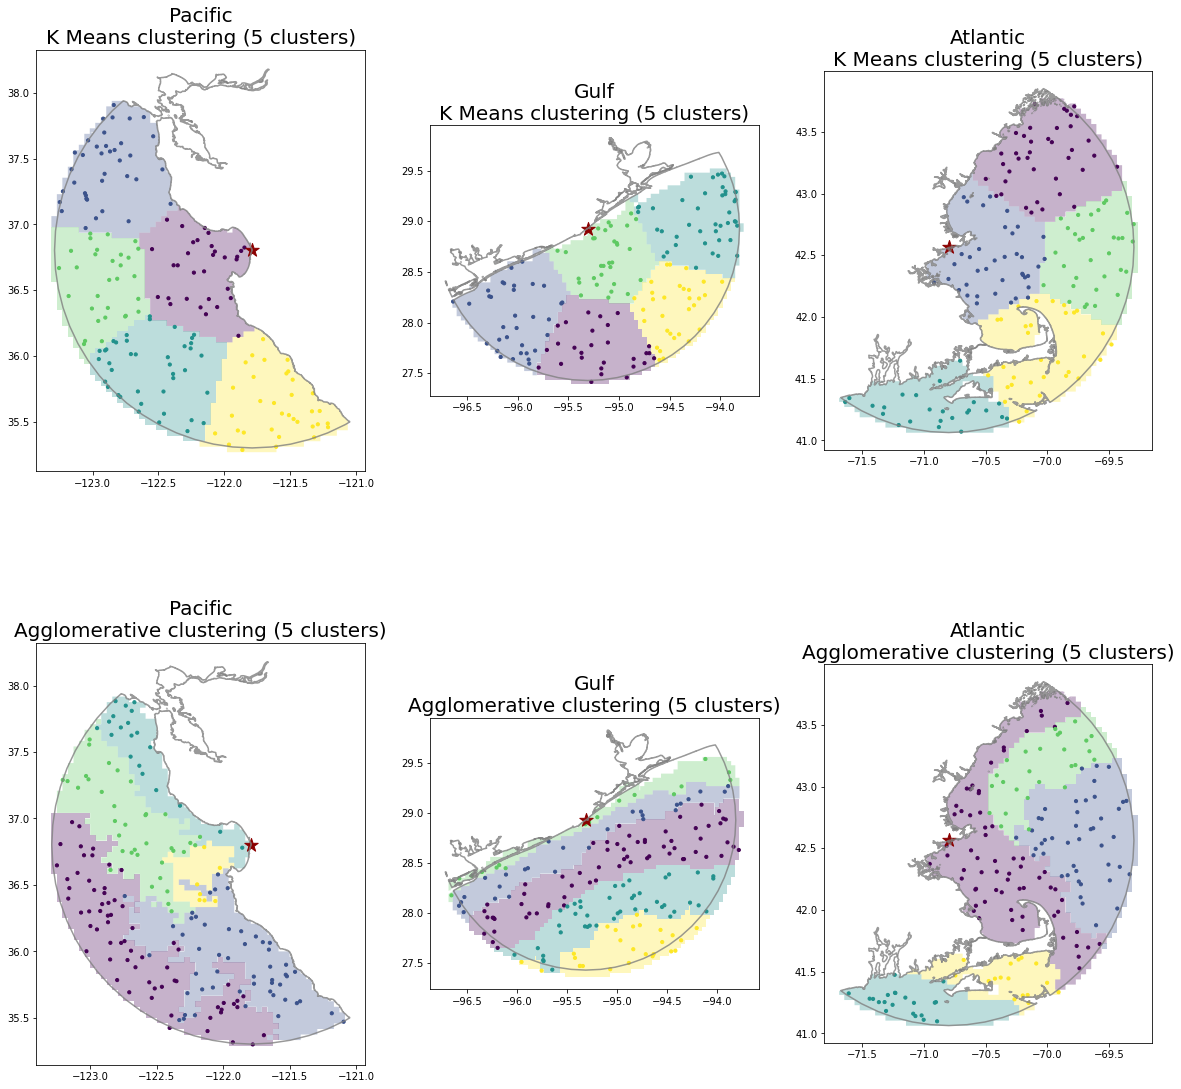

In [27]:
# plot clusters with polygons
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,20))

# PACIFIC
# kmeans
PAC[1].boundary.plot(ax=ax[0,0], alpha=0.8, color='gray') # background
PAC[3].plot(ax=ax[0,0], column='strata', alpha=0.3) # strata
PAC[5].plot(ax=ax[0,0], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[0,0], color='darkred', markersize=200, marker='*') # desalination plant
ax[0,0].set_title(f'Pacific\nK Means clustering ({CLUSTERS} clusters)') #title

# agg cluster
PAC[1].boundary.plot(ax=ax[1,0], alpha=0.8, color='gray')
PAC[4].plot(ax=ax[1,0], column='strata', alpha=0.3)
PAC[6].plot(ax=ax[1,0], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(PAC[2])).plot(ax=ax[1,0], color='darkred', markersize=200, marker='*')
ax[1,0].set_title(f'Pacific\nAgglomerative clustering ({CLUSTERS} clusters)')

# GULF
# kmeans
GUL[1].boundary.plot(ax=ax[0,1], alpha=0.8, color='gray')
GUL[3].plot(ax=ax[0,1], column='strata', alpha=0.3)
GUL[5].plot(ax=ax[0,1], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[0,1], color='darkred', markersize=200, marker='*')
ax[0,1].set_title(f'Gulf\nK Means clustering ({CLUSTERS} clusters)')
# agg cluster
GUL[1].boundary.plot(ax=ax[1,1], alpha=0.8, color='gray')
GUL[4].plot(ax=ax[1,1], column='strata', alpha=0.3)
GUL[6].plot(ax=ax[1,1], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(GUL[2])).plot(ax=ax[1,1], color='darkred', markersize=200, marker='*')
ax[1,1].set_title(f'Gulf\nAgglomerative clustering ({CLUSTERS} clusters)')

# ATLANTIC
# kmeans
ATL[1].boundary.plot(ax=ax[0,2], alpha=0.8, color='gray')
ATL[3].plot(ax=ax[0,2], column='strata', alpha=0.3)
ATL[5].plot(ax=ax[0,2], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[0,2], color='darkred', markersize=200, marker='*')
ax[0,2].set_title(f'Atlantic\nK Means clustering ({CLUSTERS} clusters)')
# agg cluster
ATL[1].boundary.plot(ax=ax[1,2], alpha=0.8, color='gray')
ATL[4].plot(ax=ax[1,2], column='strata', alpha=0.3)
ATL[6].plot(ax=ax[1,2], column='strata', markersize=10) # sample points
gpd.GeoSeries(Point(ATL[2])).plot(ax=ax[1,2], color='darkred', markersize=200, marker='*')
ax[1,2].set_title(f'Atlantic\nAgglomerative clustering ({CLUSTERS} clusters)')

plt.show()

## Evaluate sample design
### create analytical data

In [28]:
# read in pc02
p_raw = pd.read_csv(data_clean_path / 'ship_pc02_monthly.csv.gz')

In [29]:
# read annual data
ta_raw = pd.read_csv(data_clean_path / 'sst_annual.csv')
ca_raw = pd.read_csv(data_clean_path / 'chlor_a_annual.csv')

# drop and rename columns
ca_cln = (ca_raw
          .rename(columns={'below_mean':'below_mean_ca', 
                           'months_below_mean':'months_below_mean_ca',
                          'bimodal_chl':'bimodal_ca'})
          .drop(columns=['drop_below_mean', 'pacific', 'lat', 'lon']))
ta_cln = (ta_raw.drop(columns=['pacific']))

In [30]:
# merge on x/y values
a_merge = pd.merge(left=ca_cln, right=ta_cln, on=['x', 'y', 'year'], suffixes=('_ca', '_ta'))
ma = pd.merge(left=p_raw, right=a_merge, on=['x', 'y', 'year'], suffixes=(None, None))

In [31]:
# merge on x/y values
a_merge = pd.merge(left=ca_cln, right=ta_cln, on=['x', 'y', 'year'], suffixes=('_ca', '_ta'))
ma = pd.merge(left=p_raw, right=a_merge, on=['x', 'y', 'year'], suffixes=(None, None))

In [32]:
# scalarize annual variables
scale_cols = ['std_ca', 'max_ca', 'mean_ca', 'below_mean_ca', 'months_below_mean_ca', 'bimodal_ca', 'std_ta', 'max_ta', 'mean_ta']
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(ma[scale_cols])
ma_scaled = pd.DataFrame(scaler.transform(ma[scale_cols]), columns=scale_cols)
ma_scaled = pd.merge(left=ma[['lat', 'lon', 'x', 'y', 'pco2_teq']], right=ma_scaled, left_index=True, right_index=True)

### run regression

In [33]:
pred_features = ['max_t', 'std_c', 'months_below_mean', 'below_mean']
MEAN_EFFECT = 20
SD_EFFECT = 35
N_SAMPLES = 165

In [34]:
# run regression
response = 'pco2_teq'
fit_features = ['max_ta', 'std_ca', 'months_below_mean_ca', 'below_mean_ca']
X = sm.add_constant(ma_scaled[fit_features], prepend=False)
lm = sm.OLS(endog=ma_scaled[response], exog=X, hasconst=True)
res = lm.fit()

r2 = res.rsquared
res.params['const'] = MEAN_EFFECT*2.5
betas = res.params

In [75]:
print('r squared:', r2)
print(f'{SD_EFFECT} times 1 - r squared', SD_EFFECT*(1-r2))

r squared: 0.06892989442447972
35 times 1 - r squared 32.58745369514321


In [76]:
betas

max_ta                   5.898514
std_ca                  -0.946850
months_below_mean_ca     4.772212
below_mean_ca           -4.752244
const                   50.000000
dtype: float64

### simulate and score data

In [66]:
def calc_stratified_mean_se(df, strata_area, n_samples):
    mean = df.groupby('strata').mean().values.T @ strata_area
    strata_std = df.groupby('strata').std().values.T
    se_squared = strata_area**2 @ (strata_std**2 / (n_samples*strata_area)).T
    return np.concatenate((mean, np.sqrt(se_squared))).tolist()

In [81]:
def simulate_and_score(dfs, pred_features, mean_effect, sd_effect, n_samples):
    # simulate data - setup
    X_pred = sm.add_constant(dfs[0][pred_features], prepend=False)
    inv_dist_lat = np.abs(1 / (dfs[2][1] - dfs[0].lat_c))
    inv_dist_lon = np.abs(1 / dfs[0].lon_c - dfs[2][0])
    # simulate data
    yhat = pd.Series(np.random.normal(MEAN_EFFECT, SD_EFFECT, X_pred.shape[0]))
    yhat_lm = X_pred @ betas.values + np.random.normal(0, SD_EFFECT, X_pred.shape[0])*(1-r2)
    yhat_dist = X_pred @ betas.values + 0.2*inv_dist_lat + 0.2*inv_dist_lon + np.random.normal(0, SD_EFFECT*(1-r2))
    # get true data
    results = {'norm_true': [yhat.mean(), yhat.std()/np.sqrt(len(yhat))],
              'lm_true': [yhat_lm.mean(), yhat_lm.std()/np.sqrt(len(yhat_lm))],
              'dist_true': [yhat_dist.mean(), yhat_dist.std()/np.sqrt(len(yhat_dist))]}

    # get random sample
    yhat_rs = yhat.loc[np.random.randint(0, len(yhat), N_SAMPLES)]
    yhat_rs_lm = yhat_lm.loc[np.random.randint(0, len(yhat_lm), N_SAMPLES)]
    yhat_rs_dist = yhat_dist.loc[np.random.randint(0, len(yhat_dist), N_SAMPLES)]
    results['norm_rs'] = [yhat_rs.mean(), yhat_rs.std()/np.sqrt(N_SAMPLES)]
    results['lm_rs'] = [yhat_rs_lm.mean(), yhat_rs_lm.std()/np.sqrt(N_SAMPLES)]
    results['dist_rs'] = [yhat_rs_dist.mean(), yhat_rs_dist.std()/np.sqrt(N_SAMPLES)]

    # get stratified sample - make points
    kmeans_sample_locs, kmeans_area = stratified_sample(N_SAMPLES, dfs[3])
    agg_sample_locs, agg_area = stratified_sample(N_SAMPLES, dfs[4])
    # get stratified sample - merge on predictions
    df_merge = dfs[0]
    df_merge['yhat'] = yhat
    df_merge['yhat_lm'] = yhat_lm
    df_merge['yhat_dist'] = yhat_dist
    kmeans_sample_locs = gpd.sjoin_nearest(left_df=kmeans_sample_locs.set_crs(proj_crs, allow_override=True), 
                                 right_df=df_merge.set_crs(proj_crs, allow_override=True), 
                                 how='left', max_distance=0.25, distance_col='merge_dist')
    agg_sample_locs = gpd.sjoin_nearest(left_df=agg_sample_locs.set_crs(proj_crs, allow_override=True), 
                                 right_df=df_merge.set_crs(proj_crs, allow_override=True), 
                                 how='left', max_distance=0.25, distance_col='merge_dist')
    # get stratified sample - kmeans
    results['norm_srs_kmeans'] = calc_stratified_mean_se(kmeans_sample_locs[['strata', 'yhat']], kmeans_area.values, N_SAMPLES)
    results['lm_srs_kmeans'] = calc_stratified_mean_se(kmeans_sample_locs[['strata', 'yhat_lm']], kmeans_area.values, N_SAMPLES)
    results['dist_srs_kmeans'] = calc_stratified_mean_se(kmeans_sample_locs[['strata', 'yhat_dist']], kmeans_area.values, N_SAMPLES)
    # get stratified sample - agg
    results['norm_srs_agg'] = calc_stratified_mean_se(agg_sample_locs[['strata', 'yhat']], agg_area.values, N_SAMPLES)
    results['lm_srs_agg'] = calc_stratified_mean_se(agg_sample_locs[['strata', 'yhat_lm']], agg_area.values, N_SAMPLES)
    results['dist_srs_agg'] = calc_stratified_mean_se(agg_sample_locs[['strata', 'yhat_dist']], agg_area.values, N_SAMPLES)
    
    # format output
    results = pd.DataFrame(results)
    results.index = ('mean', 'se')
    results = results.reset_index()
    return results

In [82]:
# run simmulations for all oceans and summarize
sims = pd.DataFrame()
for i in tqdm(range(100)):
    s_pac = simulate_and_score(PAC, pred_features, MEAN_EFFECT, SD_EFFECT, N_SAMPLES)
    s_atl = simulate_and_score(ATL, pred_features, MEAN_EFFECT, SD_EFFECT, N_SAMPLES)
    s_gul = simulate_and_score(GUL, pred_features, MEAN_EFFECT, SD_EFFECT, N_SAMPLES)
    s_pac['coast'], s_atl['coast'], s_gul['coast'] = 'pacific', 'atlantic', 'gulf'
    sims = pd.concat((sims, s_pac, s_atl, s_gul))

100%|█████████████████████████████████████████| 100/100 [06:28<00:00,  3.89s/it]


In [83]:
# clean up summary table
sims_summ = sims.groupby(['coast', 'index']).mean().T.sort_index(ascending=False)
sims_summ.round(2)

coast           atlantic         gulf       pacific      
index               mean    se   mean    se    mean    se
norm_true          19.97  0.84  20.00  0.79   20.02  0.85
norm_srs_kmeans    20.02  2.74  20.07  2.71   19.78  2.71
norm_srs_agg       20.43  2.74  19.94  2.72   19.96  2.73
norm_rs            19.75  2.72  19.96  2.72   20.10  2.73
lm_true            38.31  0.81  51.59  0.75   31.19  0.80
lm_srs_kmeans      38.29  2.61  51.63  2.59   31.54  2.57
lm_srs_agg         39.26  2.55  52.36  2.54   30.86  2.55
lm_rs              37.99  2.63  51.76  2.58   31.08  2.58
dist_true          57.05  0.64  74.32  0.17   57.16  0.17
dist_srs_kmeans    57.47  1.95  74.76  0.58   57.19  0.47
dist_srs_agg       57.34  1.91  75.33  0.39   57.12  0.37
dist_rs            57.08  1.99  74.32  0.59   57.12  0.54